# Building a predictive model

Predicting a film genre from the raw plot summary text is best approached as a mutli-label problem since many films have multiple genres associated with them. In fact, many "subgenres" are inherently combinations of the genre labels we got from OMDb: romantic comedy (romance, comedy), scifi horror (scifi and horror...), Oscar bait (drama, war, romance), etc.

We will be working with the Sklearn package to do machine learning here. Admittedly, Sklearn is a bit limited when it comes to multi-label problems. However, random forests work well in a multi-label setting, and we do have access to those with Sklearn. In the future we will be revisiting this project with TensorFlow which is better equipped to handle the multi-label problem.

## 1. Feature engineering

At the moment the data we have are just strings of film plots. In order to ingest them into a machine learning algorithm, we will need to convert these strings into numeric features. Since we want to get as much syntactic value out of the relatively small text corpus we pulled, we will embed our text features into word vectors. There are a few steps:
1. Normalize the text to remove any unnecessary stylistic structure such as capitalization.
2. Tokenize the plots into sequence of individual tokens.
3. Remove any stop words, i.e., words that mostly communicate grammar and not content.
4. Encode the tokens as word vectors.
5. Aggregate each film's sequence of word vectors into a single feature vector.



In [1]:
import glob
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV
)
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, roc_auc_score, roc_curve,
    log_loss, precision_recall_curve
)

from scipy.stats import randint, uniform, expon, reciprocal

import nltk
import gensim

# Canonical cookie cutter start...
from dotenv import load_dotenv, find_dotenv
#find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [2]:
labels_raw = pd.read_csv(
    '../data/processed/genres_labels.csv', 
    index_col=[0, 1]
)
plots_raw = pd.read_csv(
    '../data/processed/film_plots.csv', 
    index_col=[0, 1]
)
# May want the raw data frames for later use
label_names = labels_raw.columns.values
labels = labels_raw.values
plots = plots_raw.values.flatten()

We will do the first three steps all in one go, since normalization (in our case, removing line breaks and lowercasing everything) and removing stop words is relatively easy. 

In [3]:
stopwords = nltk.corpus.stopwords.words('english')

def tokenize(plot, stopwords=None):
    if stopwords is None:
        stopwords = []
    plot = plot.replace('\n', ' ').lower()
    tokens = [
        w for sent in nltk.tokenize.sent_tokenize(plot)
        for w in nltk.tokenize.word_tokenize(sent)
        if w not in stopwords
    ]
    return tokens

plots_tokenized = [tokenize(p, stopwords) for p in plots]

In order to encode tokens into word vectors, we will need a model. We can train this from scratch with our corpus, but these data are too small to give us a good word embedding. Instead, we will use Google's pre-trained Word2Vec model (https://code.google.com/archive/p/word2vec/). 

To aggregate each instance's sequence of word vectors into a single feature vector, we will just take the mean of each coordinate. This approach is straight forward, but also gives all words in the plot equal weight. A more powerful approach may be to do a weighted average, where each token is given a weight inversely proportional to it's frequency of occurrence. This would give more weight to more uncommon words, which are more likely to be stronger indicators of genre.

Word2Vec encodes words into vectors or rank 300. Hence, our classifier will be processing 300 features per instance.

In [4]:
# Train word vectors from scratch
# model = gensim.models.Word2Vec(
#     plots_tokenized,
#     min_count=1,
#     size=20,
#     window=5
# )

# Pretrained from Google Word2Vec
# File ~1.5GB; full mapping takes ~3.5GB RAM...
model = gensim.models.KeyedVectors.load_word2vec_format(
    '../data/external/GoogleNews-vectors-negative300.bin', 
    binary=True
)
n_features = model.vector_size

In [5]:
def vectorize(tokens, model):
    """Replace tokens with word vectors from model.
    
    Words not found in the model keywords populated by
    array of nans.
    """
    default_val = np.full(model.vector_size, np.nan)
    vectors = [
        model.get_vector(t) if t in model.vocab else default_val
        for t in tokens
    ]
    return np.array(vectors)
    
plots_vectorized = [vectorize(t, model) for t in plots_tokenized]
# Aggregate to single feature vector
mean_vects = np.array([np.nanmean(v, axis=0) for v in plots_vectorized])

Now that the main preprocessing steps are complete, we need to tie them in to a machine learning pipeline. To do this with sklearn pipelines, we need to refactor the above functions to conform to the transformer api.

In [6]:
class WordVectorizer(TransformerMixin, BaseEstimator):
    """Preprocess text into word vectors.
    
    Note: The option to train word vectors from scratch is not 
    yet implemented.
        
    Parameters
    ----------
    model : Gensim model, optional (default=None)
        The model to use for encoding word vectors. If None then 
        will train word embeddings from scratch during training.
        
    stopwords : list of strings, optional (default=None)
        A list of stop words to remove from input.
        
    tokenize : bool, optional (default=True)
        Whether or not input should be tokenized. Shouls be set
        to False if being used with a different tokenization
        algorithm.
        
    """
    def __init__(self, model=None, stopwords=None, tokenize=True):
        
        self.model = model
        self.stopwords = stopwords
        self.tokenize = tokenize
        if self.model is None:
            # Instantiate gensim.model.Word2Vect and params
            raise NotImplementedError(
                   "Custom word vector training not implemented."
            )
        
    def fit(self, X, y=None):
        if self.model is not None:
            self.vectorizer_ = self.model
        else:
            # Train gensim
            pass
        return self
    
    def transform(self, X, y=None):
        stopwords = []
        if self.stopwords is not None:
            stopwords = self.stopwords
        
        def _tokenize(string):
            """Tokenize single input string."""
        
            string = string.replace('\n', ' ').lower()
            tokens = [
                w for sent in nltk.tokenize.sent_tokenize(string)
                for w in nltk.tokenize.word_tokenize(sent)
                if w not in stopwords
            ]
            return tokens
        
        def _vectorize(tokens):
            """Replace tokens with word vectors from model.

            Words not found in the model keywords populated by
            array of nans.
            
            """
            model = self.vectorizer_
            default_val = np.full(model.vector_size, np.nan)
            vectors = [
                model.get_vector(t) if t in model.vocab else default_val
                for t in tokens
            ]
            return np.array(vectors)
        
        X_tokenized = X
        if self.tokenize: 
            X_tokenized = [_tokenize(string) for string in X]
        X_vectorized = [_vectorize(t) for t in X_tokenized]
        X_vectorized = np.array([np.nanmean(v, axis=0) for v in X_vectorized])
        
        return X_vectorized

Jumping forward a little, let's make sure that the `WordVectorizer` class behaves as expected.

In [7]:
# Testing out TextVectorizer class
estimator = make_pipeline(
    WordVectorizer(
        model=model, 
        stopwords=stopwords
    ),
    RandomForestClassifier(
        random_state=42,
        n_jobs=4
    )
)
estimator.fit(plots[:5], labels[:5, :])

Pipeline(memory=None,
     steps=[('wordvectorizer', WordVectorizer(model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x10d226588>,
        stopwords=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him'...stimators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [8]:
def make_classification(plot, classifier):
    X = np.array([plot])
    probabilities = classifier.predict_proba(X)
    # Only returns 0d array if p == 1 or 0
    # This issue doesn't show up if trained on enough data for sklearn
    # to recognize that it is a multi-label problem
    probabilities = [
        x[0, 1] if x.shape == (2,) else 1 - x[0, 0] 
        for x in probabilities
    ]
    classes = list(zip(label_names, probabilities))

    classes = pd.DataFrame(classes, columns=['genre', 'probability'])
    classes = classes.set_index('genre')
    
    print(
        classes
        .sort_values('probability', ascending=False)
        .iloc[:5, :]
    )
# Test out classification pipeline
make_classification("Something involving crime and intrigue.", estimator)

         probability
genre               
drama            0.5
western          0.3
action           0.3
romance          0.2
war              0.2


Everything appears to be working (given that the model was trained on only five instances...)

## 2. Model training and tuning

To get a sense of the model's generalization error we split off a test set from our plots and labels. We can get a more robust estimate of the generalization error by using k-fold cross-validation, but are not doing so here. The model as it stands takes a fairly long time to train, even when parallelized; k-fold cross-validation expounds this, well, k-fold and my laptop can't handle it.

In [9]:
corpus_train, corpus_test, labels_train, labels_test = \
    train_test_split(plots, labels, test_size=0.2, random_state=42)

To get a baseline of model performance, let's train the model as is. We can see from the notably higher test error that the model is indeed over-fitting. 

In [10]:
# sklearn for multiclass returns list of 2d arrays
# each array index corresponds to a class
# each array represents the probabilities of being in or not in
estimator.fit(corpus_train, labels_train)

y_pred_train_raw = estimator.predict_proba(corpus_train)
y_pred_train = np.array(y_pred_train_raw)[:, :, 1].transpose()
y_pred_test_raw = estimator.predict_proba(corpus_test)
y_pred_test = np.array(y_pred_test_raw)[:, :, 1].transpose()
print(
    'train: {:.5f}'.format(log_loss(labels_train, y_pred_train)),
    '\ntest: {:.5f}'.format(log_loss(labels_test, y_pred_test))
)

train: 3.00796 
test: 15.65370


First we tune the number of trees in the forest, which is fairly decoupled from other hyper-parameters. Increasing the number of trees tends to improve model performance up to a point, but eventually becomes more of a computational burden than it is worth. It does not have a regularization effect, so we only consider how train error is influenced by number of trees. (Increasing the number of trees really only serves to decrease the variance of the model.)

In [13]:
ns = np.arange(0, 1500, 500, dtype=np.int32)
ns[0] = 100     # More reasonable starting point
loss_test = np.zeros_like(ns, dtype=np.float32)
loss_train = np.zeros_like(ns, dtype=np.float32)
for idx, n in enumerate(ns):
    # Refit with specified n_estimators
    estimator.set_params(randomforestclassifier__n_estimators=n)
    if n == ns.min():
        estimator.set_params(randomforestclassifier__warm_start=False)
    else:
        estimator.set_params(randomforestclassifier__warm_start=True)
    estimator.fit(corpus_train, labels_train)
    # Get log loss for train
    y_pred_train = estimator.predict_proba(corpus_train)
    y_pred_train = np.array(y_pred_train)[:, :, 1].transpose()
    loss_train[idx] = log_loss(labels_train, y_pred_train)
    # Get log loss for test
    y_pred_test = estimator.predict_proba(corpus_test)
    y_pred_test = np.array(y_pred_test)[:, :, 1].transpose()
    loss_test[idx] = log_loss(labels_test, y_pred_test)
    

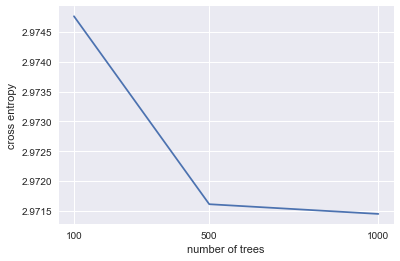

In [14]:
plt.figure()
# plt.plot(ns, loss_test, label='test')
plt.plot(ns, loss_train, label='train')
plt.xticks(ns, ns)
plt.xlabel('number of trees')
plt.ylabel('cross entropy')
plt.show()

The training loss drops off sharply, but does not improve much after about 500 trees or so. However, as we are working within a limited computational environment at the moment we will use 100 trees.

In [31]:
# Turn off warm start to retrain model
_ = estimator.set_params(randomforestclassifier__warm_start=False)
# Not making much of a difference, after 500
# _ = estimator.set_params(randomforestclassifier__n_estimators=500)

# Laptop friendly setting
_ = estimator.set_params(randomforestclassifier__n_estimators=1)

To improve the model's generalization error, we add some regularization by tuning a few hyper parameters that have regularizing effects. Since we are working on a laptop, we will just tune a few using randomized parameter search to illustrate. 

The advantage of using randomized search over grid search is two-fold:
1. Grid search gives equal weight to all hyper-parameters, regardless of how much impact they have on model performance. Randomized search tests out different values of all parameters on each iteration, and so explores parameter space more efficiently. 
2. Grid search suffers from the curse of dimensionality, i.e., as the number of hyper-parameters increases, the number of grid points needed to sufficiently explore parameter space explodes. Randomized search searches based off of probability distributions of the parameters, and so does not have this issue.

In [36]:
# Tuning some others...
params = {
    'randomforestclassifier__min_samples_split': randint(3, 20),
    'randomforestclassifier__min_samples_leaf': randint(1, 20),
    'randomforestclassifier__max_depth': randint(3, 20),
    # 'randomforestclassifier__max_features': randint(n_features // 3, n_features)
}

# Can only multithread one or the other...?
# either way were training 500 * 3 * 10 = 15,000 trees...
classifier = RandomizedSearchCV(
    estimator, params,
    cv=2, n_iter=1, random_state=42, n_jobs=1,
    scoring='roc_auc', verbose=1
)

In [37]:
classifier.fit(corpus_train, labels_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.5min finished


RandomizedSearchCV(cv=2, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('wordvectorizer', WordVectorizer(model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x10d226588>,
        stopwords=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him'...estimators=1, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'randomforestclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x6827d0eb8>, 'randomforestclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x68275b048>, 'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x68275b198>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          retur

In [38]:
# View parameters of the tuned model
classifier.best_estimator_

Pipeline(memory=None,
     steps=[('wordvectorizer', WordVectorizer(model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x62244cf60>,
        stopwords=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him'...estimators=1, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [39]:
# sklearn for multiclass returns list of 2d arrays
# each array index corresponds to a class
# each array represents the probabilities of being in or not in
y_pred_train_raw = classifier.predict_proba(corpus_train)
y_pred_train = np.array(y_pred_train_raw)[:, :, 1].transpose()
y_pred_test_raw = classifier.predict_proba(corpus_test)
y_pred_test = np.array(y_pred_test_raw)[:, :, 1].transpose()
print(
    'train: {:.5f}'.format(log_loss(labels_train, y_pred_train)),
    '\ntest: {:.5f}'.format(log_loss(labels_test, y_pred_test))
)

train: 7.55208 
test: 10.96366


## 3. Model evaluation

Since multi-label classification essentially acts as a classifier for each label, we can get a sense of the performance of the trained model by testing the model quality for each label. First we plot the receiver operator characteristic curve, along with the precision and recall curves 

In [45]:
def plot_roc(y_true, y_pred, threshold=None):
    fpr, tpr, thr = roc_curve(y_true, y_pred)
    prec, recall, thr2 = precision_recall_curve(y_true, y_pred)
    
    plt.figure(figsize=(10, 5))
    # FP vs FN
    plt.subplot(121)
    plt.step(fpr, tpr, where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    auc = roc_auc_score(y_true, y_pred)
    plt.title(f'ROC curve (AUC={auc:.5f})')
    # FP, FN vs threshold
    plt.subplot(122)
    plt.plot(thr2, prec[:-1], label='precision')
    plt.plot(thr2, recall[:-1], label='recall')
    if (threshold is not None and 
        threshold < thr2.max() and
        thr2.min() < threshold):
        plt.axvline(threshold, color='black', linestyle='--')
        plt.title(f'With classification threshold {threshold}')
    plt.xlabel('threshold')
    plt.legend(loc='upper right')
    # Finishing
    plt.tight_layout()
    
    plt.show()
    plt.close()

western


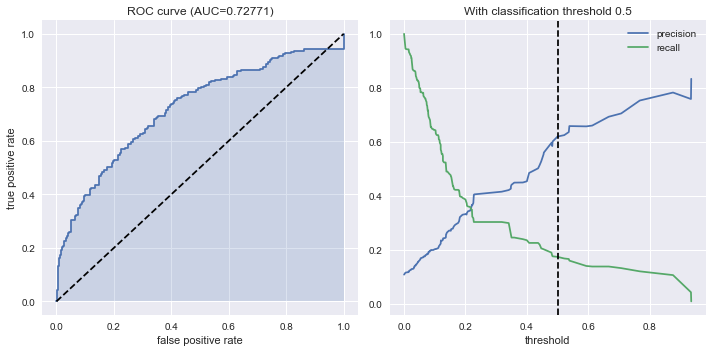

comedy


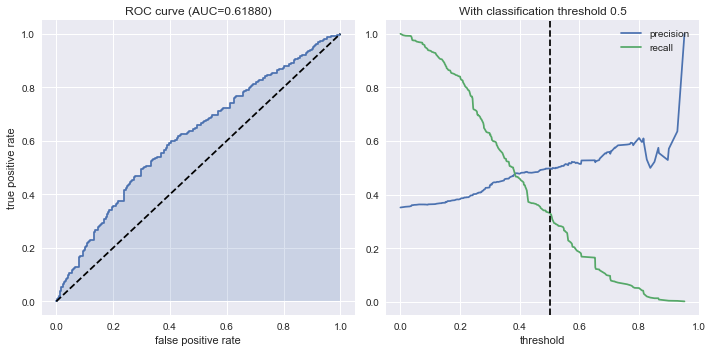

drama


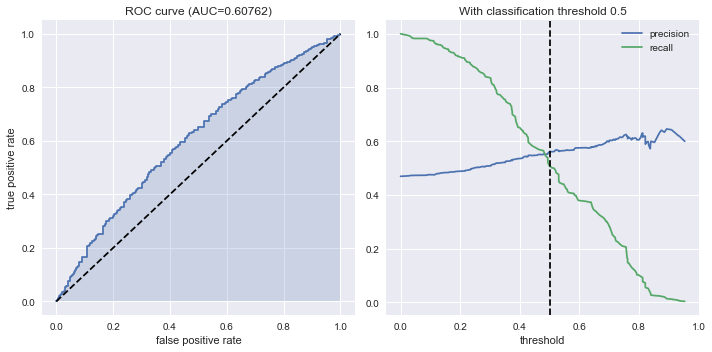

romance


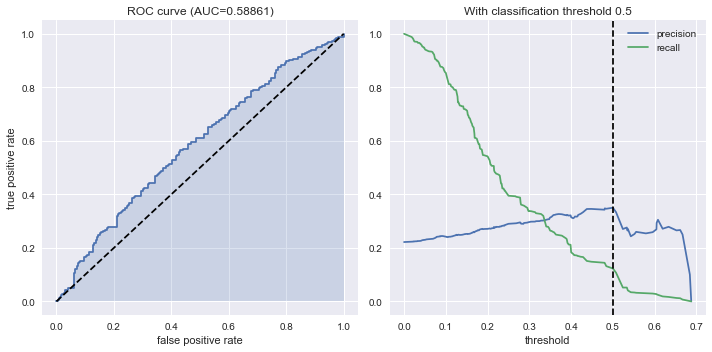

war


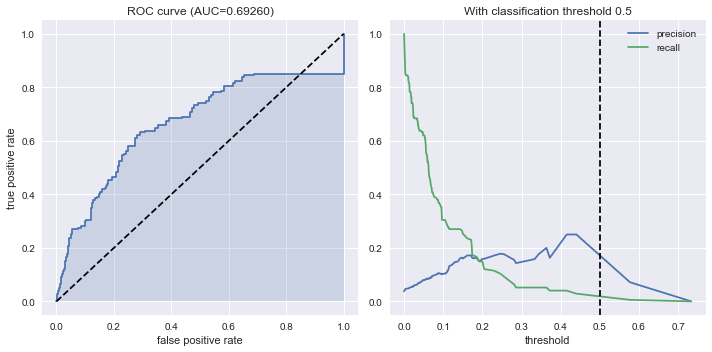

action


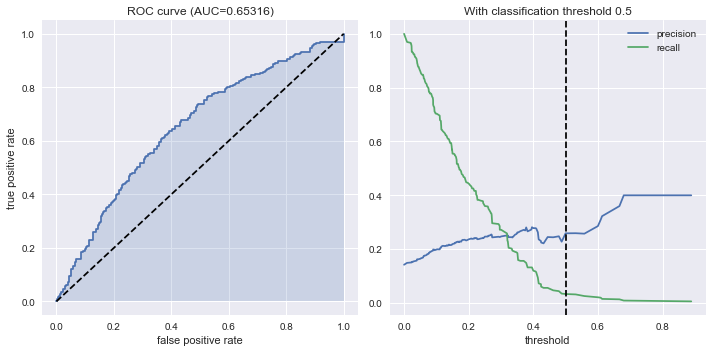

horror


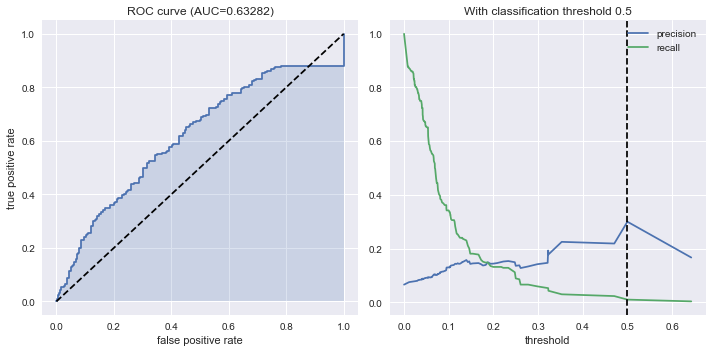

sci-fi


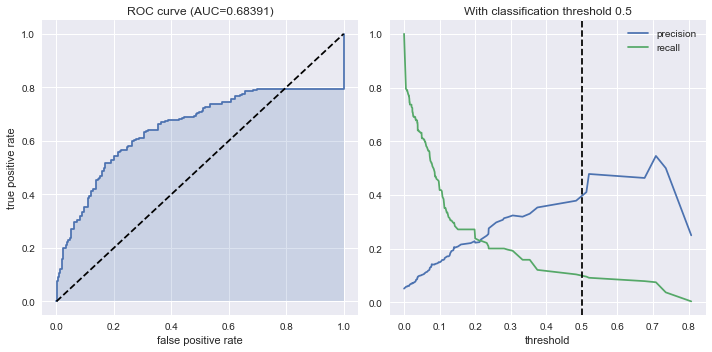

adventure


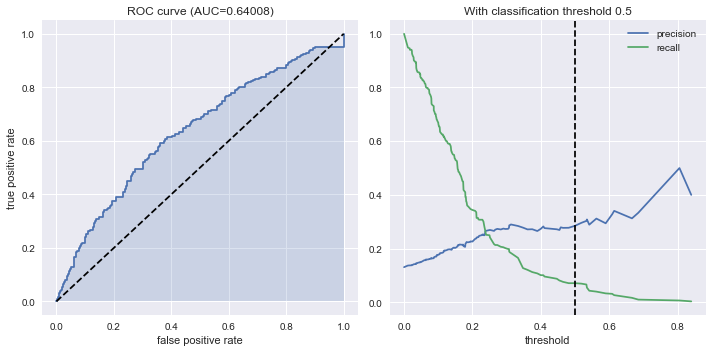

history


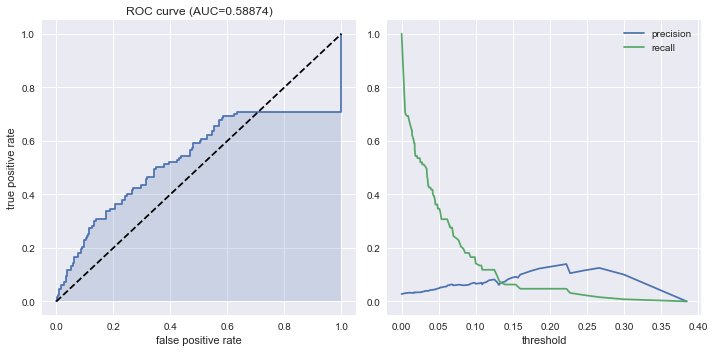

fantasy


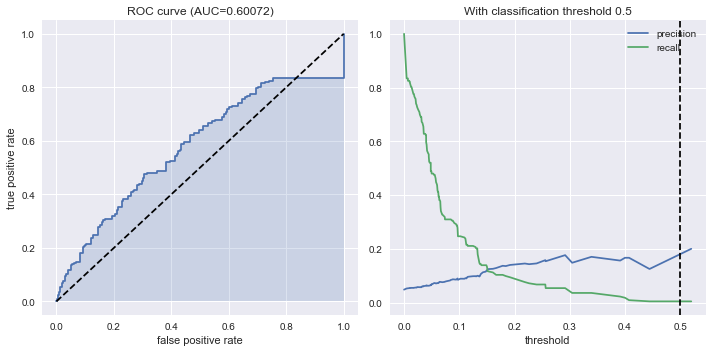

musical


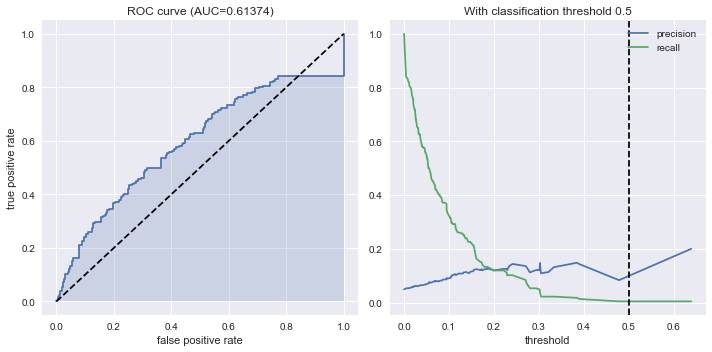

music


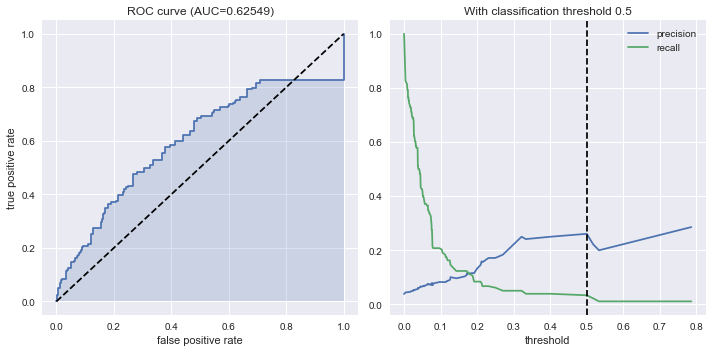

crime


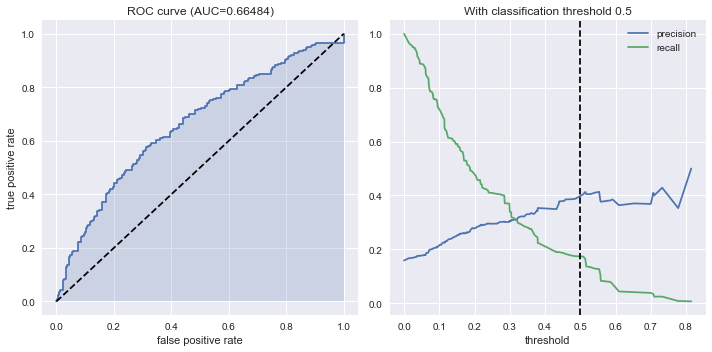

film-noir


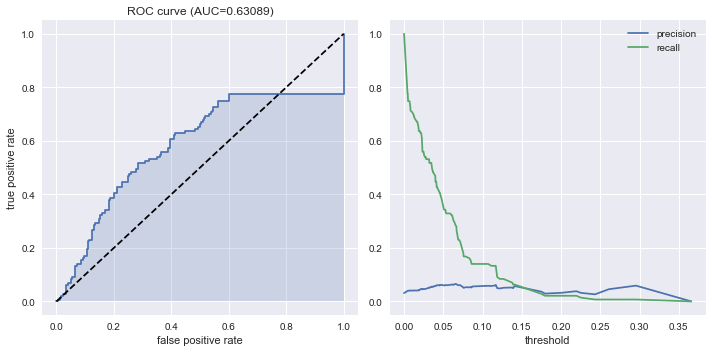

mystery


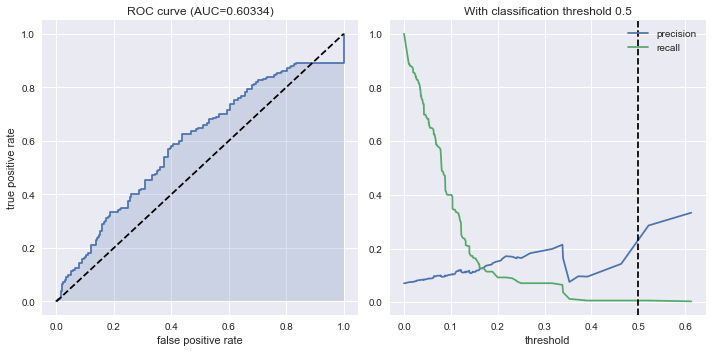

thriller


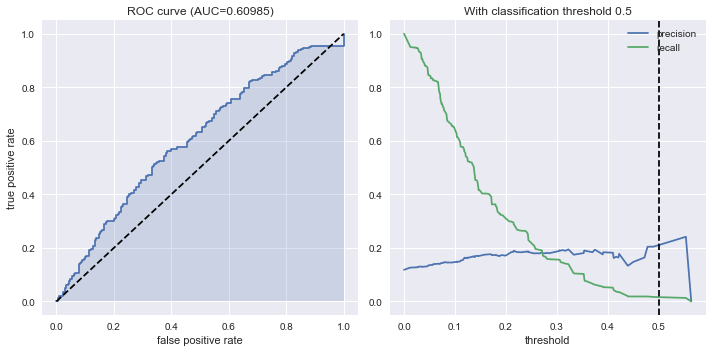

sport


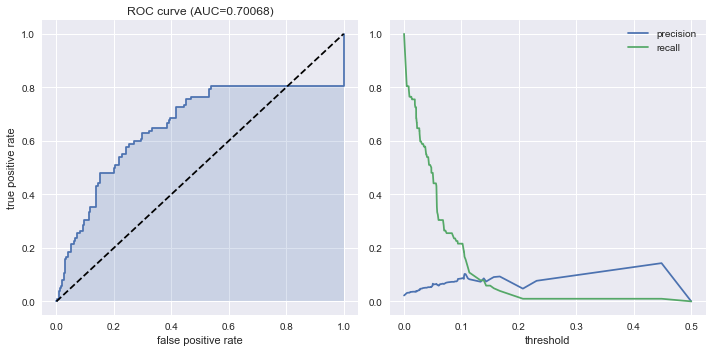

short


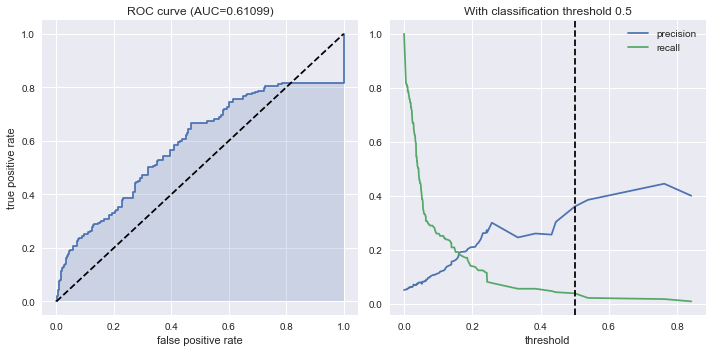

family


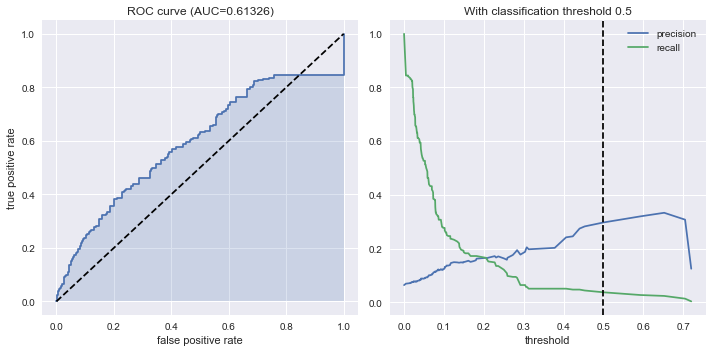

biography


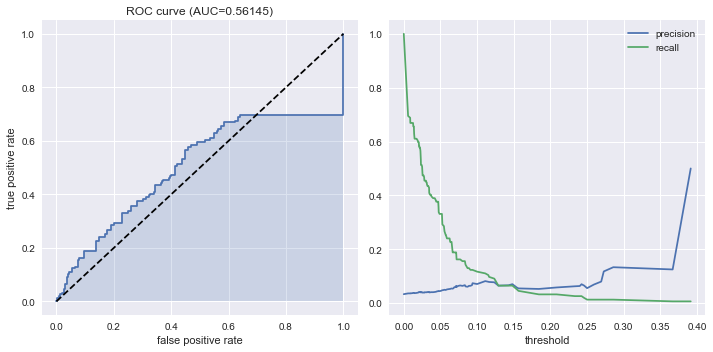

animation


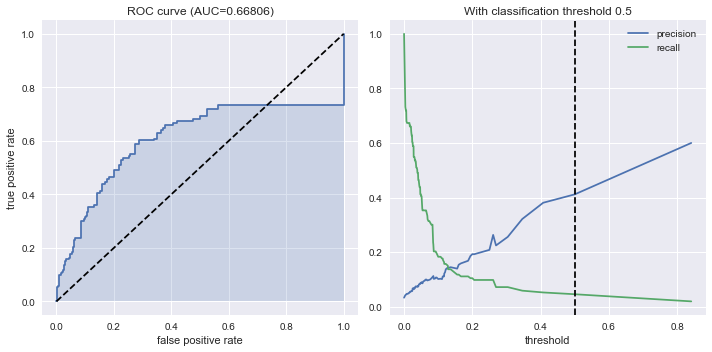

documentary


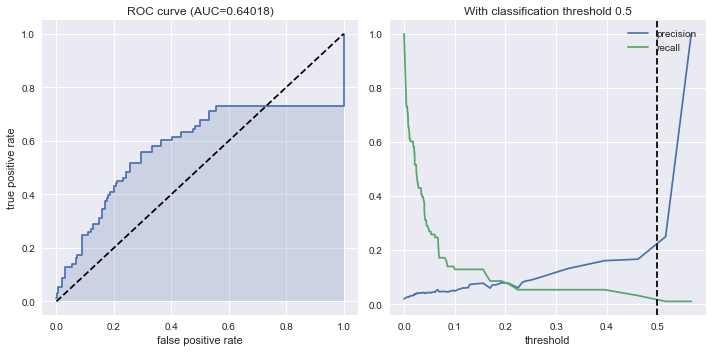

adult


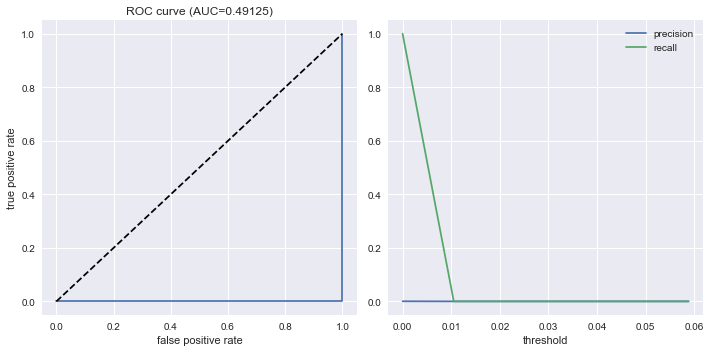

news


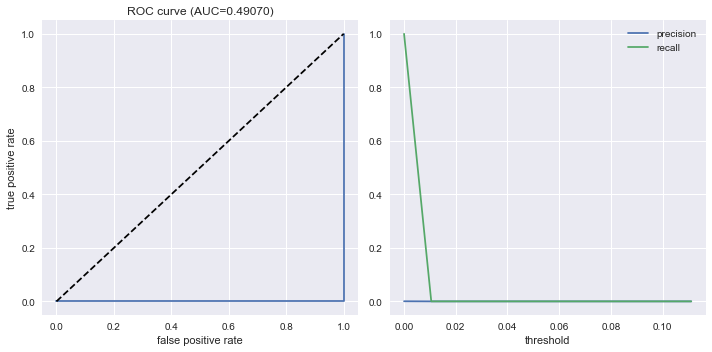

In [46]:
for idx, y_hat in enumerate(y_pred_test_raw):
    genre = label_names[idx]
    print(genre)
    y_true = labels_test[:, idx]
    plot_roc(y_true, y_hat[:, 1], threshold=0.5)

Let's also look at the model accuracy. There are two ways we will look at aggregating the individual genre accuracies:
1. Macro average, which computes the accuracy of the prediction for each genre, and then averages them together.
2. Weighted macro average, which is similar, except more weight is given to the predictions of more common genres.

In [47]:
def multilabel_accuracy(y_true, y_pred, weights=None):
    """Compute the multi-label accuracy."""
    matches = (np.around(y_true) == np.around(y_pred)).astype(np.float32)
    class_means = matches.mean(axis=0)
    if weights is None:
        # Classes given equal weight by default
        weights = np.ones_like(class_means) / len(class_means)
    assert len(weights) == len(class_means)
    weights = weights / weights.sum()  # Normalize
    return (weights * class_means).sum()

In [48]:
print(
    'macro average accuracy train: {:.5f}'.format(
        multilabel_accuracy(labels_train, y_pred_train)
    ),
    '\nmacro average accuracy test: {:.5f}'.format(
        multilabel_accuracy(labels_test, y_pred_test)
    )
)

macro average accuracy train: 0.91145 
macro average accuracy test: 0.90556


In [50]:
# When we give more common genre tags more weight accuracy goes down
weights = labels_train.sum(axis=0)
print(
    'macro weighted average accuracy train: {:.5f}'.format(
        multilabel_accuracy(labels_train, y_pred_train, weights)
    ),
    '\nmacro weighted average accuracy test: {:.5f}'.format(
        multilabel_accuracy(labels_test, y_pred_test, weights)
    )
)

macro weighted average accuracy train: 0.80815 
macro weighted average accuracy test: 0.78778
